# Statistical Static Timing Analysis via Modern Optimization Lens

## Implementation Section

We have prototyped the formulations in [CVXPY](https://www.cvxpy.org/). For benchmarking
purposes, we have rewritten the formulations of the integer programs in [Mosek’s matrix-oriented API](https://docs.mosek.com/latest/pythonapi/index.html). In this Jupyter notebook, you can find the results that ran on Mosek 10.0 on Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz with 16GB RAM.

In [1]:
import src.timing.infiniteLadder as infiniteLadder
import numpy as np
from src.timing.ScalingAlgorithms import *
import src.utility_tools.Plotter as Plotter
import sys
import subprocess

%load_ext autoreload
%autoreload 2

### GP model with fixed number of gates

Fig. 7 in the paper demonstrates the scalability of the reformulated GP on a ladder
of maxima and convolutions, parameterized by the number of bins per gate.
Notice that the numbers of cones (blue line) and variables (orange line) are
quadratic in the number of bins. At the same time, relative error decreases with the
number of bins, as expected - error of the standard deviation is indicated by orange line and mean error is indicated by
blue line in the third subplot.

In [38]:
# set parameters
numberOfIterations=8
step=15
numberOfGates=4
numBinsStart=20
interval=(-4, 25)

xs = [numberOfIterations, step, numberOfGates, numBinsStart, interval[0], interval[1]]
args = ' '.join(str(x) for x in xs)

In [39]:
# Uncomment to run on your own machine - takes 2 minutes on specified hardware
p = subprocess.run("python3 ../src/timing/ScalingAlgorithms.py GP_bins " + args + " > ../inputs_outputs/logBins.txt", shell=True)


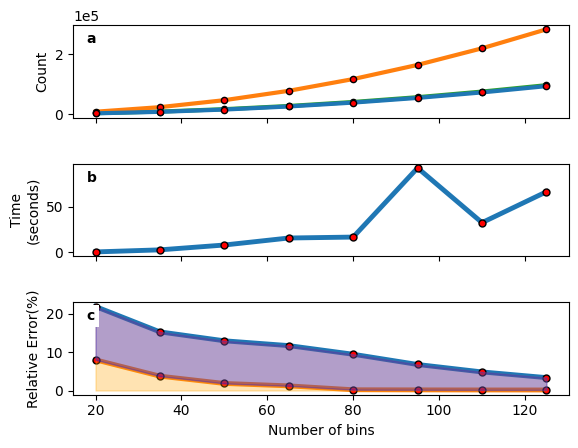

In [16]:
Plotter.plotPresolve("../inputs_outputs/logBins.txt", bins=True)

### GP model with fixed number of bins

The results on a ladder of maximums and convolutions parameterized
by the depth of the ladder are shown in Fig. 6 in the paper. Notice that the numbers of
cones (blue line) and variables (orange line) are linear in the depth of the
ladder. At the same time, the relative error
increases, which may be due to the fixed number of bins utilized. Relative error of the standard deviation is indicated by orange line and relative error of the mean is indicated by
blue line in the third subplot.

In [2]:
# set parameters
numberOfIterations=6
step=2
numberOfBins=60
numGatesStart=1
interval=(-4, 25)

xs = [numberOfIterations, step, numberOfBins, numGatesStart, interval[0], interval[1]]
args = ' '.join(str(x) for x in xs)

In [3]:
# Uncomment to run on your own machine - takes 2 minutes on specified hardware
p = subprocess.run("python3 ../src/timing/ScalingAlgorithms.py GP_gates " + args + " > ../inputs_outputs/logGates.txt", shell=True)


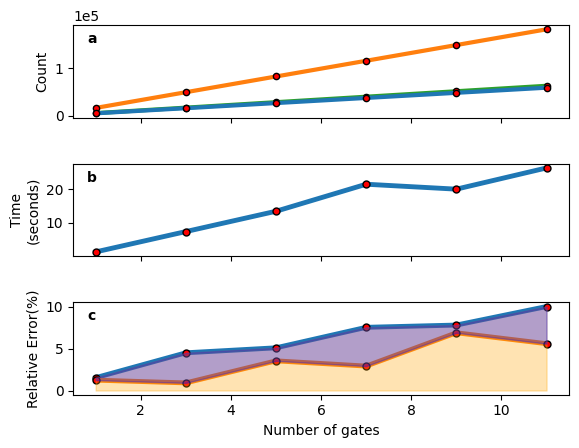

In [15]:
Plotter.plotPresolve("../inputs_outputs/logGates.txt", bins=False)

### MIP model - Comparison

Comparison of 3 methods of the SSTA realization. The methods are
tested on a “ladder” of maximums and convolutions. The blue line indicates the original method, the orange line indicates a method with separation
constraints and the green line indicates a method with separation constraints and a three-term multiplication model.

In [4]:
# set parameters 
numberOfIterations=4
step=2
numberOfBins=12
numGatesStart=1
numberOfUnaries=12
interval=(-4, 25)

In [5]:
       # test integer program with and without relaxations - takes 10 
TRI = False
Constr = False
res1 = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)

TRI = False
Constr = True
res2 = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)

TRI = True
Constr = True
res3 = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)


Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 75192           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 32688           
  Matrix variables       : 0               
  Integer variables      : 32688           

Optimizer started.
Mixed integer optimizer started.
Threads used: 8
Presolve started.
Presolve terminated. Time = 0.06, probing time =  0.00
Presolved problem: 79 variables, 183 constraints, 494 non-zeros
Presolved problem: 2 general integer, 77 binary, 0 continuous
Clique table size: 120
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        -0.0000000000e+00    NA                   NA          0.2   
0        1        1        0        -0.0000000000e+

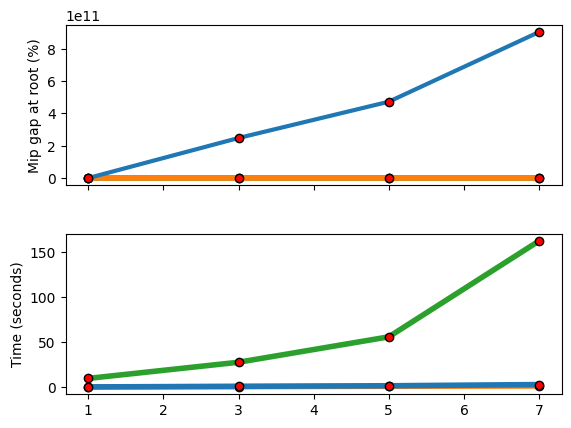

In [7]:
# Plot the results 
# - blue line indicates the unrelaxed problem
# - orange line indicates relaxed problem with symmetry breaking constraints
# - green line indicates the fully relaxed

Plotter.plotComparison(res1, res2, res3)

### Relaxed problem using MIP

In [9]:
# set parameters
numberOfIterations=5
step=1
numberOfBins=25
numGatesStart=1
numberOfUnaries=20
interval=(-4, 25)

In [10]:
# test 1. relaxation
TRI = False
Constr = True
res = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 890050          
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 382500          
  Matrix variables       : 0               
  Integer variables      : 382500          

Optimizer started.
Mixed integer optimizer started.
Threads used: 8
Presolve started.
Presolve terminated. Time = 0.94, probing time =  0.01
Presolved problem: 1165 variables, 3250 constraints, 8707 non-zeros
Presolved problem: 5 general integer, 1160 binary, 0 continuous
Clique table size: 2160
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        -0.0000000000e+00    NA                   NA          2.2   
0        1        1        0        1.300000

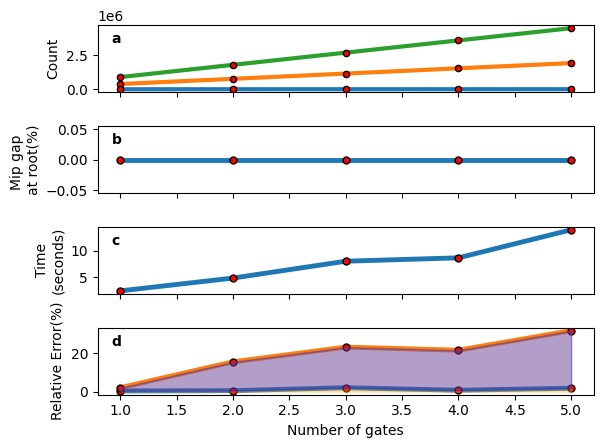

In [ ]:
Plotter.plotNonzeros(res)

In [50]:
# set parameters for the fully relaxed problem
numberOfIterations=4
step=1
numberOfBins=10
numGatesStart=1
numberOfUnaries=10
interval=(-4, 25)

In [51]:
# test full relaxation - which does not scale so well

TRI = True
Constr = True
resFullRelaxation = AlgorithmsScaling_MOSEK(numberOfIterations=numberOfIterations, step=step, numberOfBins=numberOfBins,
                      numberOfGatesStart=numGatesStart, interval=interval, numberOfUnaries=numberOfUnaries,
                             TRI=TRI, Constr=Constr)

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : LO (linear optimization problem)
  Constraints            : 1540100         
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 385400          
  Matrix variables       : 0               
  Integer variables      : 385400          

Optimizer started.
Mixed integer optimizer started.
Threads used: 8
Presolve started.
Presolve terminated. Time = 1.31, probing time =  0.00
Presolved problem: 51 variables, 149 constraints, 407 non-zeros
Presolved problem: 0 general integer, 51 binary, 0 continuous
Clique table size: 111
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        5.0000000000e+00     NA                   NA          3.5   
0        1        1        0        5.0000000000e+0

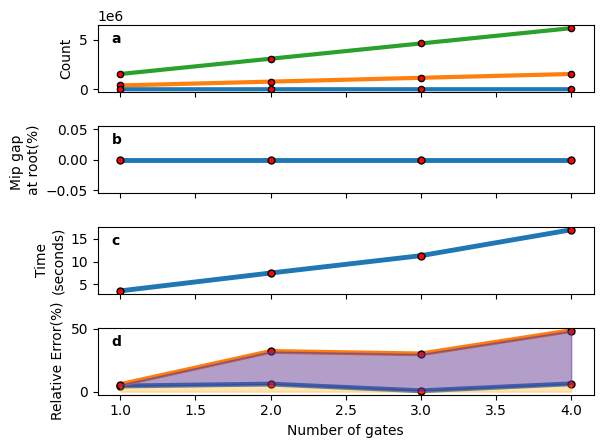

In [52]:
Plotter.plotNonzeros(resFullRelaxation)